<a href="https://colab.research.google.com/github/AndresMontesDeOca/TimeSeries/blob/main/Machete_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machete Series Temporales

## Imortamos Librerias

In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf


import warnings
warnings.filterwarnings('ignore')

## Cargamos el Dataset

In [188]:
url='https://raw.githubusercontent.com/sebcalcagno/AnalisisSeriesTemporales/main/Index2018.csv'
raw_csv_data = pd.read_csv(url)
data = raw_csv_data.copy()

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6277 entries, 0 to 6276
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6277 non-null   object 
 1   spx     6277 non-null   float64
 2   dax     6277 non-null   float64
 3   ftse    6277 non-null   float64
 4   nikkei  6277 non-null   float64
dtypes: float64(4), object(1)
memory usage: 245.3+ KB
None


,date,spx,dax,ftse,nikkei
0,7/1/1994,469.90,2224.95,3445.98,18124.01
1,10/1/1994,475.27,2225.00,3440.58,18443.44
2,11/1/1994,474.13,2228.10,3413.77,18485.25
3,12/1/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


## Pre-Procesamiento

In [189]:
# Convertiamos a Date, formato DD/MM/YYYY
data['date'] = pd.to_datetime(data['date'], dayfirst=True).copy()

# Seteamos 'date' como Index
data.set_index('date', inplace=True)

# Nos quedamos solo con 'spx', para simplificar
data.drop(columns=['dax', 'ftse', 'nikkei'], inplace=True)

# Renombramos spx a SPX
data.rename(columns={'spx':'SPX'}, inplace=True)

# Adaptamos distintas frecuencias temporales
# display(data.asfreq('b').head()) # Business Day
# data.asfreq('d').head() # Completa dias faltantes con null
# data.asfreq('m').head() # Mes
# data.resample(rule='QS').max # Agrupa por Cuartos, y muestra el Max de cada uno

data.head()

,SPX
date,
1994-01-07,469.90
1994-01-10,475.27
1994-01-11,474.13
1994-01-12,474.17
1994-01-13,472.47


## Visualizacion

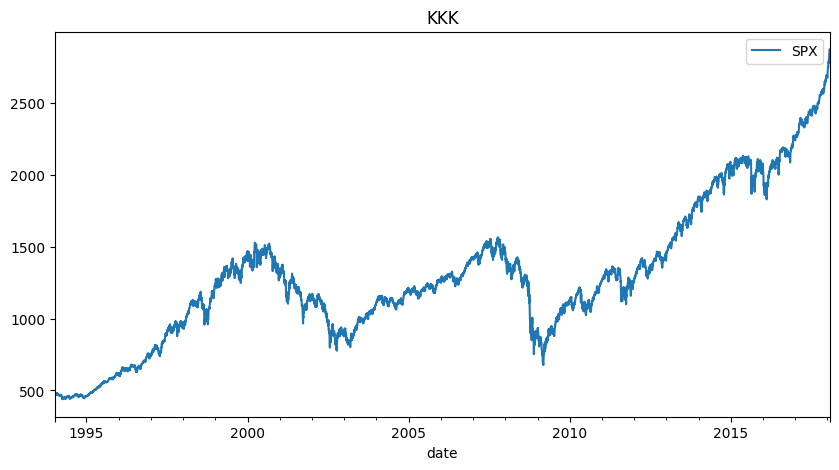

In [190]:
# Visualizamos
data.plot(figsize=(10, 5), title='KKK')
# plt.plot(data)

plt.show()

## Determinamos Rolling Statistics (Moving Averages?)

In [227]:
# Get the data of the stock TSLA
data_tesla = yf.download('TSLA', '2017-01-01', '2022-02-25')[['Open']]

# Calculate Moving Average, then concatenate
data_tesla_ma = data_tesla.rolling(window=30).mean().rename(columns={'Open':'SMA'})
data_tesla = pd.concat([data_tesla, data_tesla_ma], axis=1).copy()

# Confirmo el Simple Moving Averge
display(data_tesla['SMA'].iloc[29])
print('Mean de los primeros 30:', data_tesla['Open'][:30].mean().round(6))

[*********************100%%**********************]  1 of 1 completed


16.365266799926758

Mean de los primeros 30: 16.365267


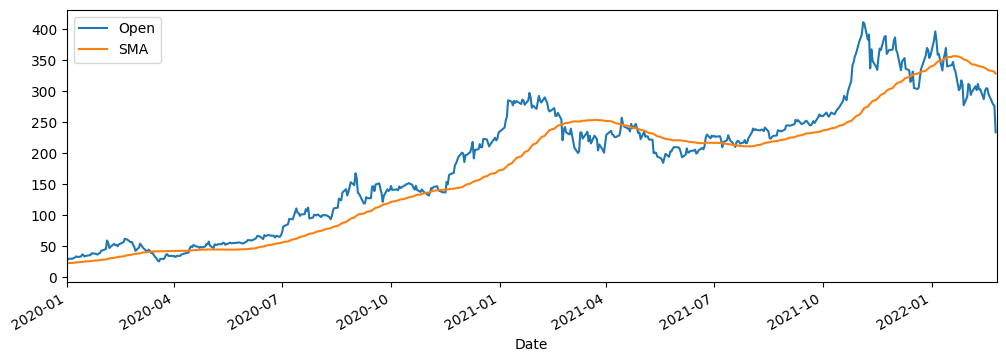

In [220]:
data_tesla.plot(figsize=(12, 4), xlim=['2020-01-01', '2022-02-25'])
plt.show()

In [203]:
# Funcion que calcula ambos Rolling Statistics (Mean and Desv)

def calculate_rolling_statitics (serie):
  RM = pd.Series(serie.rolling(window=5).mean(), name='RM')
  RSD = pd.Series(serie.rolling(window=5).std(), name='RSD')
  df = pd.concat([serie, RM, RSD], axis=1)
  return df

In [192]:
# Pasamos SPX a la funcion

data_rs = calculate_rolling_statitics(data['SPX'])
display(data_rs.tail())

,SPX,RM,RSD
date,,,
2018-01-23,2839.130362,2816.598595,18.421901
2018-01-24,2837.544008,2823.596282,18.399263
2018-01-25,2839.253031,2831.840837,12.306302
2018-01-26,2872.867839,2844.353868,16.141743
2018-01-29,2853.528411,2848.464730,15.102985


## Ploteamos Rolling Statistics

<Axes: xlabel='date'>

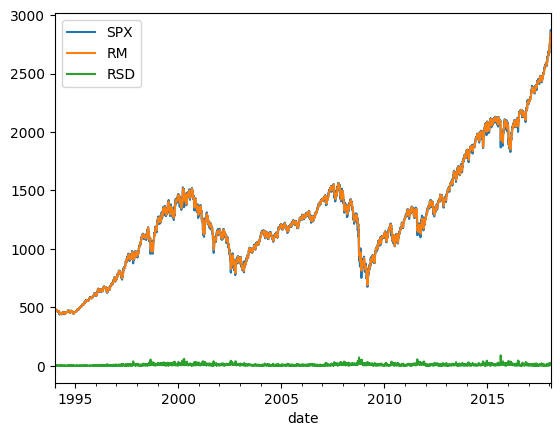

In [124]:
# Confirmar si esta bien
data_rs.plot()

# Para que sean Estacionarias, RM y RSD deberian ser constantes. RM no lo es

## Test Analitico Augmented Dickey–Fuller (ADCF)
H0: La serie es No-Estacionaria

In [125]:
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf, pacf


# Realizo el test y me traigo solo el p-value
adfuller(data)[1]

# No puedo rechazar H0 de No-Estacionariedad

0.9953796476080692

## Test Grafico Funcion de Autocorrelacion (ACF)

Trend = Decrece Linealmente\
Seasonality = Aparecen Valles


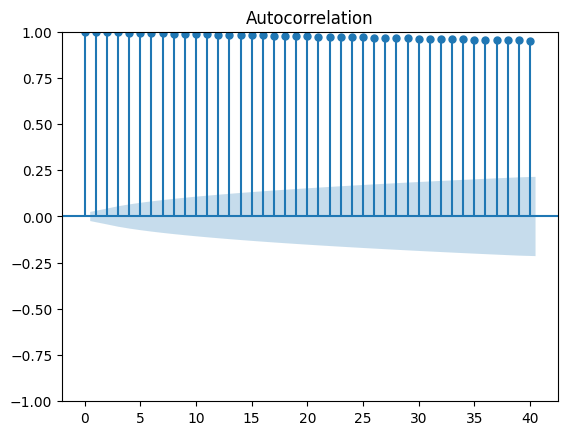

In [126]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, lags=40)
plt.show()

## Descomposicion de la Serie (no entiendo para que sirve)

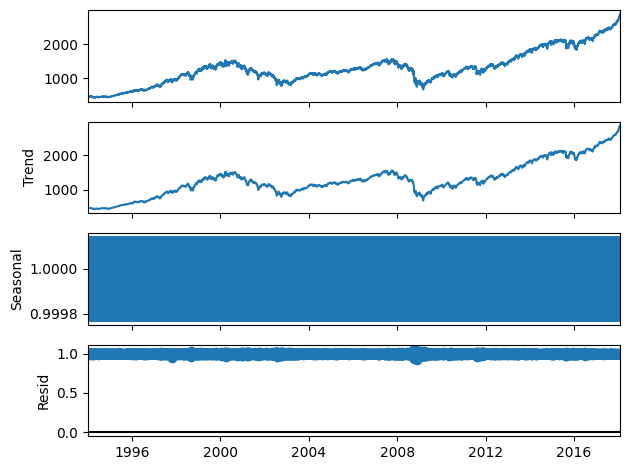

In [127]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_dec = seasonal_decompose(data, model='multiplicative', period=None) # aditive
data_dec.plot()
plt.show()

## Aplicamos una Transformacion y la Graficamos

,SPX,SPX_shift1
date,,
1994-01-07,469.90,5.37
1994-01-10,475.27,-1.14
1994-01-11,474.13,0.04
1994-01-12,474.17,-1.70
1994-01-13,472.47,2.44


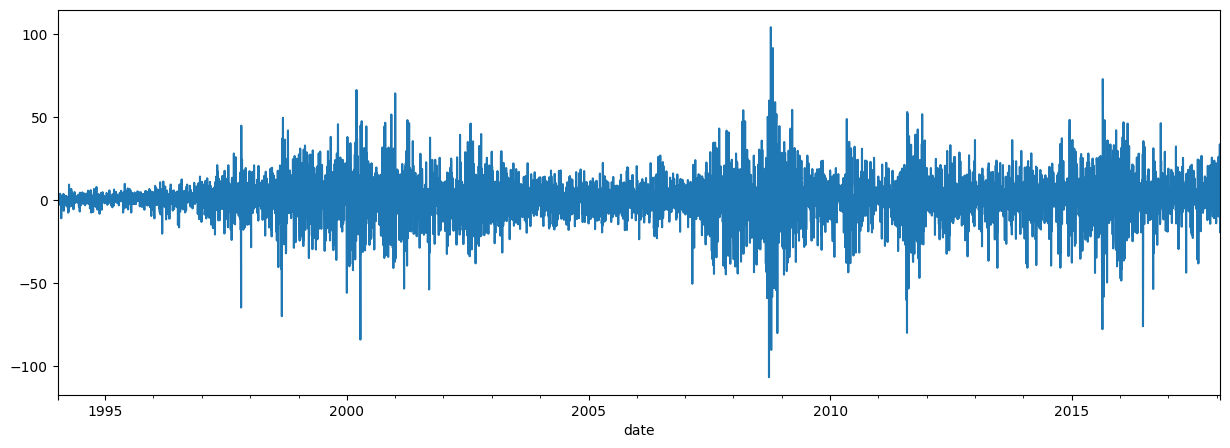

(6277, 2)


In [128]:
# Calculamos la primer diferencia
# data['SPX_shift1'] = data.shift(-1) - data # Equivalente
data['SPX_shift1'] = -data.diff(-1) # Equivalente

# IMPORTANTISIMO -> Eliminar Nulos
# data.dropna(inplace=True)
data.fillna(0, inplace=True)

# Print y graficamos
display(data.head())
data['SPX_shift1'].plot(figsize=(15, 5))
plt.show()

print(data.shape)

## Analizamos la Transformacion

P-Value: 1.9598823765918135e-26


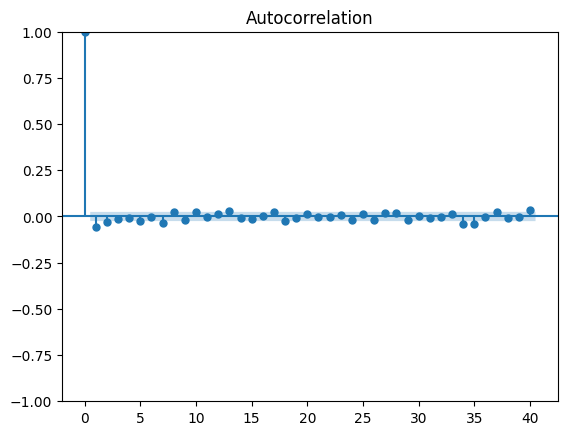

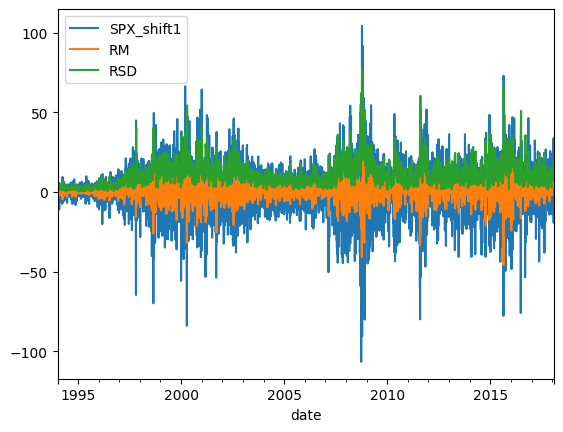

In [129]:
# ADCF Test
print('P-Value:', adfuller(data['SPX_shift1'])[1])

# Autocorrelation ACF Test
plot_acf(data['SPX_shift1'], lags=40)
plt.show()

# Vemos los Moving Average
calculate_rolling_statitics(data['SPX_shift1']).plot()
plt.show()